In [1]:
"%^%" <- function(M, power)
  with(eigen(M), vectors %*% (values^power * solve(vectors)))

In [2]:
#library(mlbench)

#set.seed(1,)
#objekt <- mlbench.spirals(100,1,0.025)
#podatki <- objekt$x
#plot(podatki)

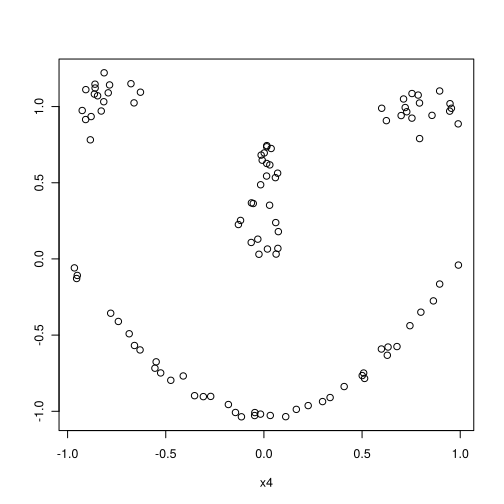

In [3]:
library(mlbench)

set.seed(5)
objekt <- mlbench.smiley(n=100, sd1 = 0.1, sd2 = 0.025)
podatki <-  objekt$x
plot(podatki)

Potrebujem matriko, ki doloca, kako blizu sta x in y med seboj. Za mero bom izbral Gaussian Kernel: ce sta dve tocki blizu, je GK ~ 1, ce pa sta dalec narazen pa GK ~ 0. Dodaten pogoj: ce norma med tockama xi in xj vec kot r, bo S[i,j] = 0.

In [4]:
s <- function(x1, x2, alpha=1) {
    exp(- alpha * norm(as.matrix(x1-x2), type="F")) #frobeniusova norma
}

In [5]:
podobnostna.matrika <- function(podatki, razdalja, r = 1) {
  N <- nrow(podatki)
  S <- matrix(rep(NA,N^2), ncol=N) #ustvarim prazno matriko
  for(i in 1:N) {
    for(j in 1:N) {
        if (norm(as.matrix(podatki[i,]-podatki[j,]), type="F") >= r) {
            S[i,j] <- 0
        } else {
            S[i,j] <- razdalja(podatki[i,], podatki[j,])
       }
    }
  }
  S
}

In [102]:
S <- podobnostna.matrika(podatki, s, 0.5) #problem negativnih lastnih vrednosti, ce bo r majhen
#S[1:8,1:8]

Tip grafa: k-najblizjih sosedov, popoln graf (st.sosedov = N )

In [103]:
affinity.matrika <- function(S, st.sosedov=2) {
  N <- length(S[,1])

  if (st.sosedov >= N) { #poln graf
    A <- S
  } else {
    A <- matrix(rep(0,N^2), ncol=N) #prazna matrika
    for(i in 1:N) {
      najboljsa.ujemanja <- sort(S[i,], decreasing=TRUE)[1:st.sosedov] #povezem tiste, kateri so blizji
      for (s in najboljsa.ujemanja) {
        j <- which(S[i,] == s)
        A[i,j] <- S[i,j]
        A[j,i] <- S[i,j] #simetricna matrika - neusmerjen graf
      }
    }
  }
  A  
}


In [104]:
A <- affinity.matrika(S, 10) #povezem tiste, ki imajo visoke vrednosti
#A[1:8,1:8]

In [105]:
D <- diag(apply(A, 1, sum)) #vsota vrstic
#D[1:8,1:8]

Poracunam normalizirano Laplaceovo matriko (symmetric matrix = I - D^(-1/2)*A*D^(-1/2))

In [106]:
Lsym <- (D %^% (-1/2)) %*% A %*% (D %^% (-1/2))
#round(Lsym[1:10,1:10],1)

Stevilo k je stevilo dreves, v katere hocem povezat podatke. Poracunam prvih k-najmanjsih lastnih vektorjev.

In [120]:
k   <- 41
lastne_vrednosti <- eigen(Lsym, symmetric = TRUE)
Z   <- lastne_vrednosti$vectors[,(ncol(lastne_vrednosti$vectors)-k+1):ncol(lastne_vrednosti$vectors)]

Formuliramo novo matriko, ki ima vrstice dolge 1.

In [121]:
T <- matrix(rep(0,k*nrow(Z)), ncol=k)
Q <- matrix(rep(0,k*nrow(Z)), ncol=k)
for(i in 1:nrow(Z)) {
      for (j in 1:k) {
        Q[i,j] = Z[i,j]^2
       }
      }

for(i in 1:nrow(Z)) {
    suma = sqrt(sum(Q[i,]))
      for (j in 1:k) {
        if (suma == 0) {
            T[i,j] <- 0
        } else {
            T[i,j] <- Z[i,j]/suma
       }
      }
    }

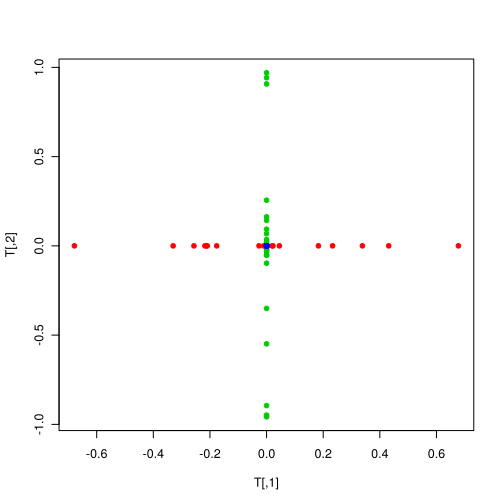

In [122]:
plot(T, col=objekt$classes, pch=20)

Uporabim k-means algoritem.

Warning message:
“did not converge in 10 iterations”

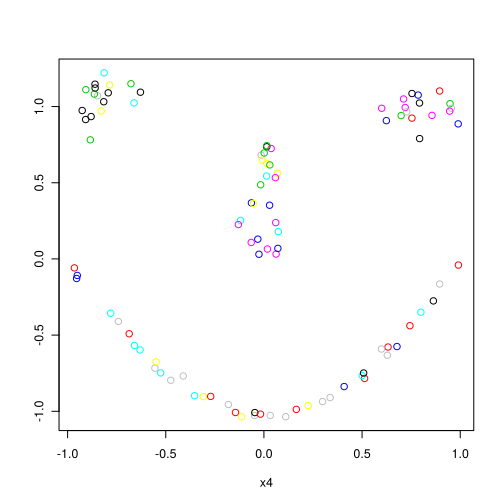

In [123]:
library(stats)
km <- kmeans(T, centers=k)
plot(podatki, col=km$cluster)

In [124]:
lastne_vrednosti$values[lastne_vrednosti$values <= 0] <- 1e-16 #problem negativnih lastnih vrednosti
signif(lastne_vrednosti$values,2) #absolutne lastne vrednosti, saj pridejo nekatere negativne

1 
 1 
 1 
 1 
 0.97 
 0.94 
 0.89 
 0.72 
 0.63 
 0.53 
 0.5 
 0.48 
 0.47 
 0.32 
 0.28 
 0.25 
 0.2 
 0.17 
 0.12 
 0.11 
 0.1 
 0.099 
 0.093 
 0.091 
 0.087 
 0.086 
 0.079 
 0.077 
 0.077 
 0.072 
 0.06 
 0.056 
 0.054 
 0.05 
 0.044 
 0.044 
 0.042 
 0.039 
 0.029 
 0.027 
 0.025 
 0.021 
 0.014 
 0.011 
 0.0092 
 0.0077 
 0.0072 
 0.0072 
 0.0056 
 0.0054 
 0.0054 
 0.0049 
 0.0049 
 0.0045 
 0.004 
 0.004 
 0.0039 
 0.0038 
 0.0037 
 0.0035 
 0.0034 
 0.0033 
 0.003 
 0.003 
 0.003 
 0.0025 
 0.002 
 0.0013 
 0.0011 
 8e-04 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16 
 1e-16

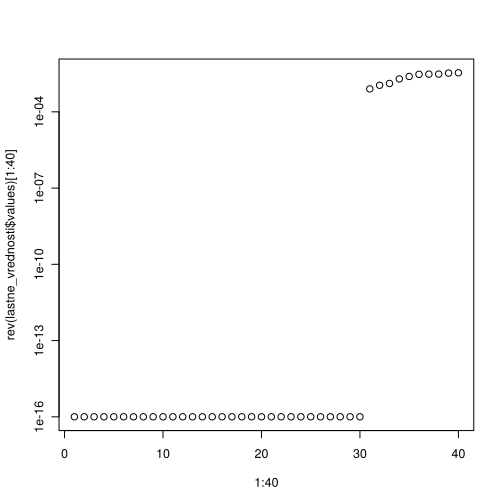

In [125]:
plot(1:40, rev(lastne_vrednosti$values)[1:40], log = "y")